#Installing Dependencies

In [1]:
!pip install numpy pandas tensorflow nltk rouge-score python-docx

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 3.4 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=904b4d8c253e22290f20d555cacf0c35c1c880b2e91588ac365bd5a157eed9a8
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


# Language Model with Sequence Prediction

This notebook demonstrates the creation of a language model that predicts the next word in a sequence. It uses a variety of models such as SimpleRNN, LSTM, GRU, and BiLSTM. We also integrate word embeddings, preprocess text data, and evaluate the models on accuracy.

## Libraries and Setup

We begin by importing the necessary libraries and downloading required NLTK resources.

In [18]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback
from tensorflow.keras.optimizers import Adam

# Load and preprocess text data

In [19]:
with open(r'/content/merged_text (4).txt', 'r') as file:
    text = file.read().lower()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])
sequences = tokenizer.texts_to_sequences([text])[0]

vocab_size = len(tokenizer.word_index) + 1

# Create training sequences
sequence_length = 10
input_sequences = []
for i in range(sequence_length, len(sequences)):
    input_sequences.append(sequences[i-sequence_length:i+1])

input_sequences = np.array(pad_sequences(input_sequences))
x, y = input_sequences[:,:-1], input_sequences[:,-1]
y = tf.keras.utils.to_categorical(y, num_classes=vocab_size)

#  Load pre-trained word embeddings

In [20]:
embeddings_index = {}
embeddings_df = pd.read_csv(r'/content/word_embeddings.csv')
for i, row in embeddings_df.iterrows():
    embeddings_index[row['word']] = row.iloc[1:].values.astype('float32')

embedding_dim = len(list(embeddings_index.values())[0])
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in embeddings_index:
        embedding_matrix[i] = embeddings_index[word]

# Build the RNN model and Training

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback
import numpy as np

# Define the model with more complexity
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], input_length=sequence_length, trainable=False))
model.add(LSTM(256, return_sequences=True))  # Increased LSTM units
model.add(Dropout(0.3))  # Increased Dropout
model.add(LSTM(256))  # Increased LSTM units
model.add(Dense(512, activation='relu'))  # Added additional dense layer with more units
model.add(Dropout(0.3))  # Added dropout to avoid overfitting
model.add(Dense(vocab_size, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

# Callbacks for saving models and weights at each epoch
checkpoint_word2vec = ModelCheckpoint('word2vec_modelcheckpoint.keras', save_weights_only=False, monitor='val_loss', mode='min', verbose=1)
checkpoint_embedding_matrix = LambdaCallback(on_epoch_end=lambda epoch, logs: np.save('embedding_matrix_checkpoint.npy', embedding_matrix))

# Saving model weights at each epoch
checkpoint_model_weights = ModelCheckpoint('model_checkpoint_epoch_{epoch:02d}.weights.h5', save_weights_only=True, monitor='val_loss', mode='min', verbose=1)
checkpoint_best_model = ModelCheckpoint('best_model.weights.h5', save_weights_only=True, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

# Train the model with validation split and callbacks
history = model.fit(x, y, epochs=30, validation_split=0.2, batch_size=64, callbacks=[checkpoint_word2vec, checkpoint_embedding_matrix, checkpoint_model_weights, checkpoint_best_model])


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │          67,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 67,080 (262.03 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 67,080 (262.03 KB)

Epoch 1/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.0564 - loss: 6.8948
Epoch 1: saving model to word2vec_modelcheckpoint.keras

Epoch 1: saving model to model_checkpoint_epoch_01.weights.h5

Epoch 1: val_loss improved from inf to 6.92313, saving model to best_model.weights.h5
127/127 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - accuracy: 0.0564 - loss: 6.8931 - val_accuracy: 0.0615 - val_loss: 6.9231
Epoch 2/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.0692 - loss: 6.2711
Epoch 2: saving model to word2vec_modelcheckpoint.keras

Epoch 2: saving model to model_checkpoint_epoch_02.weights.h5

Epoch 2: val_loss did not improve from 6.92313
127/127 ━━━━━━━━━━━━━━━━━━━━ 22s 169ms/step - accuracy: 0.0692 - loss: 6.2713 - val_accuracy: 0.0615 - val_loss: 7.1424
Epoch 3/30
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.0657 - loss: 6.2220
Epoch 3: saving model to word2vec_modelcheckpoint.keras

Epoch 3: saving model to model_checkpoint_epoch_03.weights.h5

Epo

## Plotting Training and Validation Accuracy and Losses

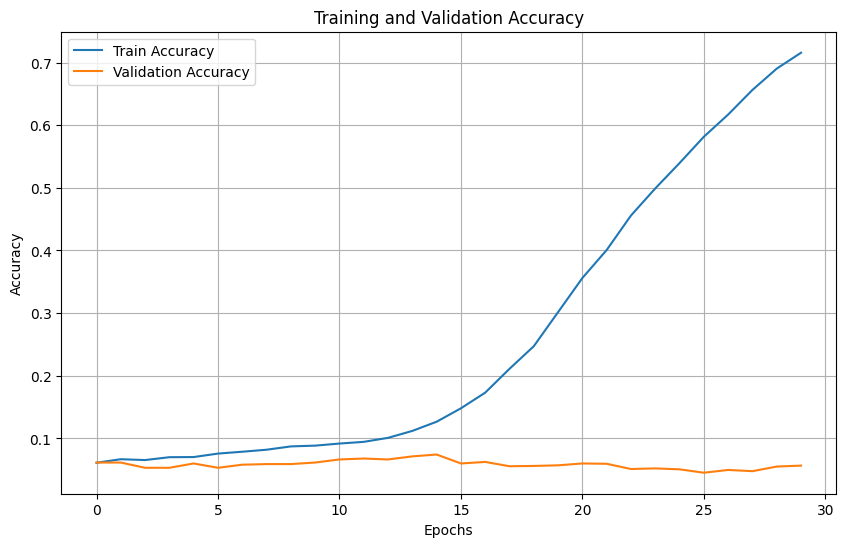

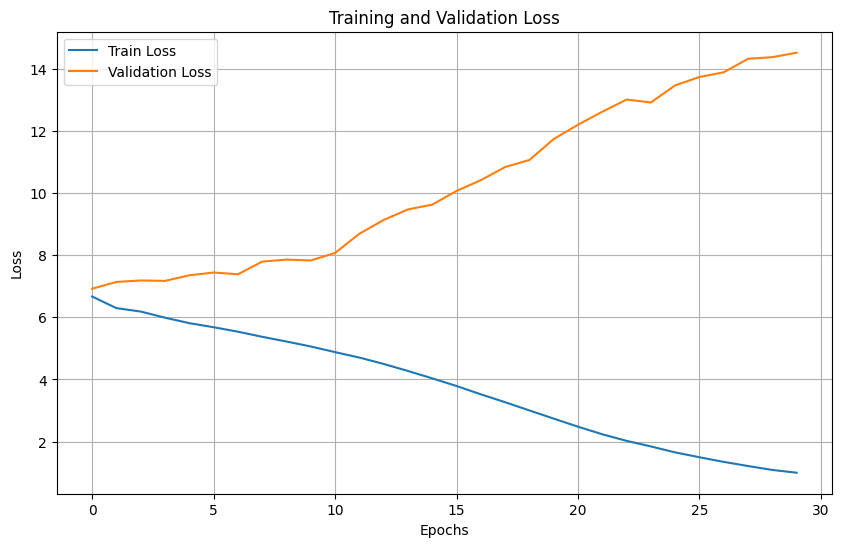

In [25]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
# History contains 'accuracy', 'val_accuracy', 'loss', and 'val_loss'

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('train_val_accuracy.png')
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('train_val_loss.png')
plt.show()

## Generating Text and Evaluating on Bleu and Rogue Sore

In [26]:
# Function to generate text
def generate_text(seed_text, next_words, tokenizer, model, sequence_length):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=sequence_length, padding='pre')
        predicted = np.argmax(model.predict(token_list), axis=-1)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
    return seed_text

# Example of different seed texts to generate text
seed_texts = [
    "the federal board",
    "students are preparing",
    "machine learning is powerful",
    "the weather is great today",
    "deep learning models are evolving"
]

next_words = 20  # Number of words to generate for each seed text

# Generate text for each seed text
generated_texts = [generate_text(seed_text, next_words, tokenizer, model, sequence_length) for seed_text in seed_texts]

# Print generated texts
for idx, generated_text in enumerate(generated_texts, 1):
    print(f"Generated Text {idx}: {generated_text}")
    print("===")

# Actual sequences (Example)
actual_sequences = [
    ['the', 'federal', 'board', 'exam', 'is', 'difficult'],
    ['students', 'are', 'preparing', 'for', 'the', 'exam'],
    ['machine', 'learning', 'is', 'powerful'],
    ['the', 'weather', 'is', 'beautiful', 'today'],
    ['deep', 'learning', 'models', 'are', 'advancing']
]

# Tokenizing generated texts for BLEU and ROUGE
predicted_sequences = [text.split() for text in generated_texts]

# BLEU Score computation
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
smooth_fn = SmoothingFunction().method1  # Smoothing function for BLEU scores

# Computing BLEU score for each sentence pair
bleu_scores = [sentence_bleu([actual], pred, smoothing_function=smooth_fn)
               for actual, pred in zip(actual_sequences, predicted_sequences)]

# Compute corpus-level BLEU scores with different n-gram weights
bleu_1 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(0.5, 0.5, 0, 0))
bleu_3 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(0.33, 0.33, 0.33, 0))
bleu_4 = corpus_bleu([[a] for a in actual_sequences], predicted_sequences, weights=(0.25, 0.25, 0.25, 0.25))

# Printing BLEU scores
print("BLEU Scores:")
print(f"BLEU-1: {bleu_1:.4f}")
print(f"BLEU-2: {bleu_2:.4f}")
print(f"BLEU-3: {bleu_3:.4f}")
print(f"BLEU-4: {bleu_4:.4f}")

# ROUGE Score computation
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
# Initialize cumulative ROUGE scores with offsets for clarity
rouge_1, rouge_2, rouge_l = 0, 0, 0

# Iterate over actual and predicted sequences
for actual, pred in zip(actual_sequences, predicted_sequences):
    # Converting sequences to strings for scoring
    actual_str = ' '.join(actual)
    pred_str = ' '.join(pred)
    # Computing ROUGE scores for the pair
    scores = scorer.score(actual_str, pred_str)
    rouge_1 += scores['rouge1'].fmeasure  # Accumulate ROUGE-1 F1 scores
    rouge_2 += scores['rouge2'].fmeasure  # Accumulate ROUGE-2 F1 scores
    rouge_l += scores['rougeL'].fmeasure  # Accumulate ROUGE-L F1 scores

# 6. Print training and validation accuracy and loss
print("Training Accuracy: ", max(history.history['accuracy']))
print("Validation Accuracy: ", max(history.history['val_accuracy']))
print("Training Loss: ", max(history.history['loss']))
print("Validation Loss: ", max(history.history['val_loss']))

# Averaging ROUGE scores over all sequences
n = len(actual_sequences)
print("\nROUGE Scores:")
print(f"ROUGE-1 (F1): {rouge_1 / n:.4f}")
print(f"ROUGE-2 (F1): {rouge_2 / n:.4f}")
print(f"ROUGE-L (F1): {rouge_l / n:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 716ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━